# **Tutorial for cell-cell communication prediction for non-single-cell ST data with DeepTalk**
The notebook introduces to predicting cell-cell comunication using the DeepTalk method.

The notebook uses data from mouse brain cortex.

In [1]:
import sys
import os
import random
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
from anndata import AnnData
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import skimage
import json
import seaborn as sns
import copy
from orderedset import OrderedSet
import DeepTalk_ST as dt
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## **Loading datasets**
Load public data available in Squidpy, from mouse brain cortex. 
Single cell data are stored in ```adata_sc```. Spatial data, in ```adata_st```..

In [2]:
adata_st = sq.datasets.visium_fluo_adata_crop()
adata_st = adata_st[
    adata_st.obs.cluster.isin([f"Cortex_{i}" for i in np.arange(1, 5)])
].copy()
img = sq.datasets.visium_fluo_image_crop()
adata_sc = sq.datasets.sc_mouse_cortex()

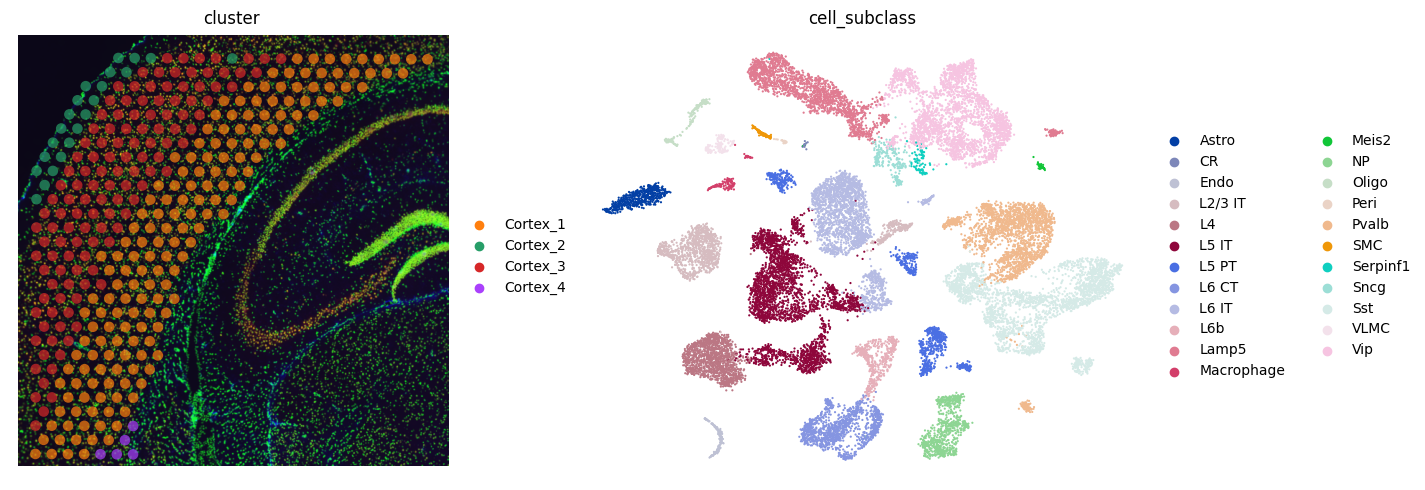

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sc.pl.spatial(
    adata_st, color="cluster", alpha=0.7, frameon=False, show=False, ax=axs[0]
)
sc.pl.umap(
    adata_sc, color="cell_subclass", size=10, frameon=False, show=False, ax=axs[1]
)
plt.tight_layout()

## **Pre-processing**

Quality control is applied to single-cell data, as the data has already been preprocessed, this step can be skipped. Different quality control standards should be applied to different data

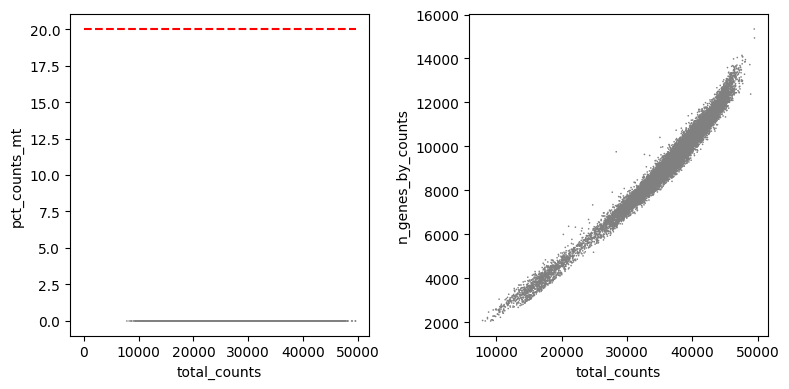

In [4]:
adata_sc.var["mt"] = adata_sc.var_names.str.startswith(r'^(mt-|MT-)')
sc.pp.calculate_qc_metrics(
    adata_sc, qc_vars=["mt"], inplace=True, percent_top=[20], log1p=True
)


fig, axs = plt.subplots(ncols = 2, figsize = (8,4))
sc.pl.scatter(adata_sc, x='total_counts', y='pct_counts_mt',ax = axs[0], show=False)
sc.pl.scatter(adata_sc, x='total_counts', y='n_genes_by_counts',ax = axs[1], show = False)
'''
adata_sc = adata_sc[adata_sc.obs['pct_counts_mt'] < 20]  
adata_sc = adata_sc[adata_sc.obs['n_genes_by_counts'] < 16000]  
adata_sc = adata_sc[adata_sc.obs['total_counts'] < 55000]
'''

#draw horizontal red lines indicating thresholds.
axs[0].hlines(y = 20, xmin = 0, xmax = max(adata_sc.obs['total_counts']), color = 'red', ls = 'dashed') 
fig.tight_layout()
plt.show()

In [5]:
sc.pp.filter_cells(adata_sc, min_genes=200)
sc.pp.filter_genes(adata_sc, min_cells=3)
adata_sc_raw = copy.deepcopy(adata_sc)
sc.pp.normalize_total(adata_sc)
sc.pp.log1p(adata_sc)
adata_st_raw = copy.deepcopy(adata_st)
sc.pp.normalize_total(adata_st)
sc.pp.log1p(adata_st)

In order to deconvolve cells, **DeepTalk** needs to know how many cells are present in each voxel. This is achieved by segmenting the cells on the corresponding histology, which squidpy makes possible with two lines of code: ```squidpy.im.process``` applies smoothing as a pre-processing step. - ```squidpy.im.segment``` computes segmentation masks with watershed algorithm.

In [6]:
sq.im.process(img=img, layer="image", method="smooth")

sq.im.segment(
    img=img,
    layer="image_smooth",
    method="watershed",
    channel=0
)

Let’s visualize the segmentation results for an inset

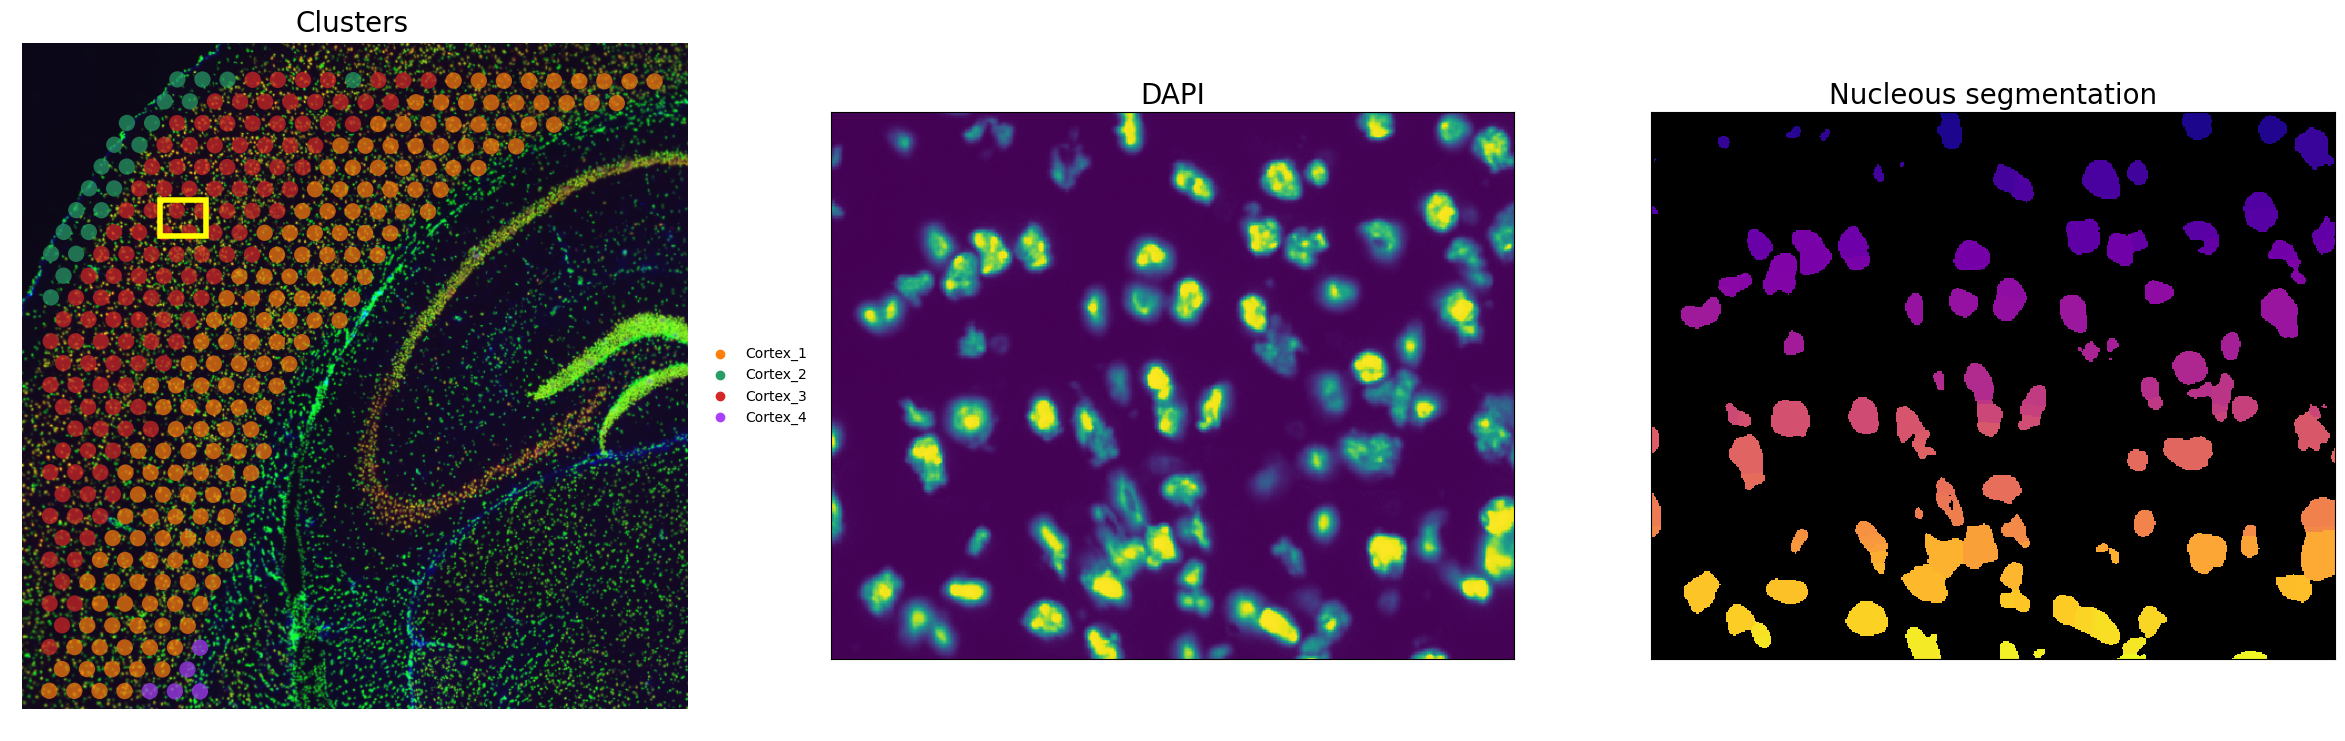

In [7]:
inset_y = 1500
inset_x = 1700
inset_sy = 400
inset_sx = 500

fig, axs = plt.subplots(1, 3, figsize=(30, 10))
sc.pl.spatial(
    adata_st, color="cluster", alpha=0.7, frameon=False, show=False, ax=axs[0], title=""
)
axs[0].set_title("Clusters", fontdict={"fontsize": 20})
sf = adata_st.uns["spatial"]["V1_Adult_Mouse_Brain_Coronal_Section_2"]["scalefactors"][
    "tissue_hires_scalef"
]
rect = mpl.patches.Rectangle(
    (inset_y * sf, inset_x * sf),
    width=inset_sx * sf,
    height=inset_sy * sf,
    ec="yellow",
    lw=4,
    fill=False,
)
axs[0].add_patch(rect)

axs[0].axes.xaxis.label.set_visible(False)
axs[0].axes.yaxis.label.set_visible(False)

axs[1].imshow(
    img["image"][inset_y : inset_y + inset_sy, inset_x : inset_x + inset_sx, 0, 0]
    / 65536,
    interpolation="none",
)
axs[1].grid(False)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title("DAPI", fontdict={"fontsize": 20})

crop = img["segmented_watershed"][
    inset_y : inset_y + inset_sy, inset_x : inset_x + inset_sx
].values.squeeze(-1)
crop = skimage.segmentation.relabel_sequential(crop)[0]
cmap = plt.cm.plasma
cmap.set_under(color="black")
axs[2].imshow(crop, interpolation="none", cmap=cmap, vmin=0.001)
axs[2].grid(False)
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_title("Nucleous segmentation", fontdict={"fontsize": 20});

Comparison between DAPI and mask confirms the quality of the segmentation. We then need to extract some image features useful for the deconvolution task downstream. Specifically: - the number of unique segmentation objects (i.e. nuclei) under each spot. - the coordinates of the centroids of the segmentation object.

In [8]:
# define image layer to use for segmentation
features_kwargs = {
    "segmentation": {
        "label_layer": "segmented_watershed",
        "props": ["label", "centroid"],
        "channels": [1, 2],
    }
}

sq.im.calculate_image_features(
    adata_st,
    img,
    layer="image",
    key_added="image_features",
    features_kwargs=features_kwargs,
    features="segmentation",
    mask_circle=True,
)

  0%|          | 0/324 [00:00<?, ?/s]

In [9]:
adata_st.obsm['image_features']

segmentation_label  \
AAATGGCATGTCTTGT-1                  13   
AACAACTGGTAGTTGC-1                  15   
AACAGGAAATCGAATA-1                  28   
AACCCAGAGACGGAGA-1                   5   
AACCGTTGTGTTTGCT-1                   7   
...                                ...   
TTGGATTGGGTACCAC-1                  25   
TTGGCTCGCATGAGAC-1                   5   
TTGTATCACACAGAAT-1                  22   
TTGTGGCCCTGACAGT-1                  25   
TTGTTAGCAAATTCGA-1                  27   

                                                segmentation_centroid  
AAATGGCATGTCTTGT-1  [[5304.0, 731.0], [5320.947519118759, 721.3315...  
AACAACTGGTAGTTGC-1  [[1583.0, 4233.828793585227], [1671.5717336342...  
AACAGGAAATCGAATA-1  [[5028.0, 1061.4293230016444], [5042.200781827...  
AACCCAGAGACGGAGA-1  [[1185.0, 1012.0], [1257.9561167460154, 1023.3...  
AACCGTTGTGTTTGCT-1  [[4619.0, 381.72603026366806], [4627.707819057...  
...                                                               ...  
TTGGATTGGGTACCAC-1  [[3379.0, 1609.5027775295625], [3430.128033605...  
TTGGCTCGCATGAGAC-1  [[902.0, 3035.1389252487215], [913.41811041094...  
TTGTATCACACAGAAT-1  [[5992.0, 333.5593226506872], [6001.0050156143...  
TTGTGGCCCTGACAGT-1  [[4064.0, 1794.9633829463617], [4082.278586090...  
TTGTTAGCAAATTCGA-1  [[1589.0, 2787.4719677445705], [1597.800292086...  

[324 rows x 2 columns]

We can visualize the total number of objects under each spot with scanpy.


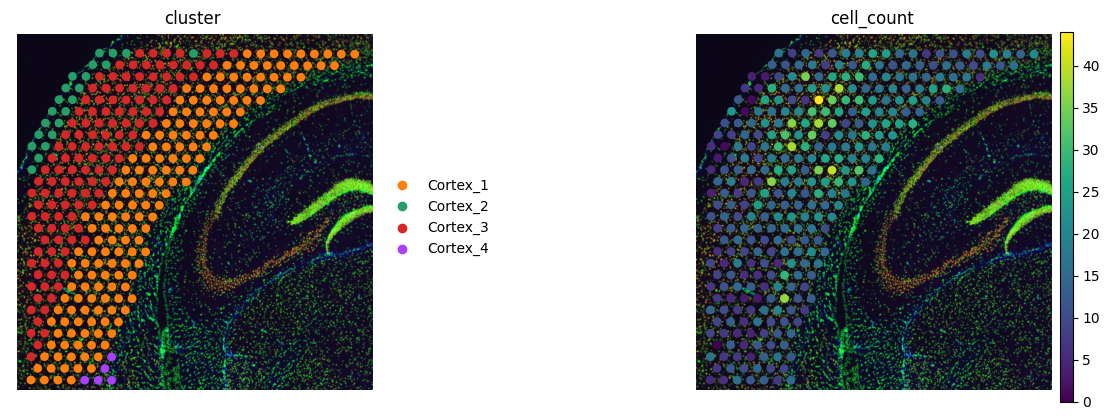

In [10]:
adata_st.obs["cell_count"] = adata_st.obsm["image_features"]["segmentation_label"]
sc.pl.spatial(adata_st, color=["cluster", "cell_count"], frameon=False)

For this case, we use 1291 marker genes as training genes.


In [11]:
sc.tl.rank_genes_groups(adata_sc, groupby="cell_subclass", use_raw=False)
markers_df = pd.DataFrame(adata_sc.uns["rank_genes_groups"]["names"]).iloc[0:100, :]
markers = list(np.unique(markers_df.melt().value.values))
len(markers)

1291

In [12]:
dt.pp_adatas(adata_sc, adata_st, genes=markers)

INFO:root:1187 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:14785 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


## **Deconvolution via DeepTalk**

In [13]:
ad_map = dt.map_cells_to_space(
    adata_sc=adata_sc,
    adata_sp=adata_st,
    learning_rate=0.0005,
    num_epochs=2000,
    #device='cpu', 
    device='cuda:0',
)

Start training
Epoch 100, Loss: -0.683,Score0: 0.683,Time: 0.994
Epoch 200, Loss: -0.688,Score0: 0.688,Time: 0.999
Epoch 300, Loss: -0.691,Score0: 0.691,Time: 1.005
Epoch 400, Loss: -0.694,Score0: 0.694,Time: 1.008
Epoch 500, Loss: -0.697,Score0: 0.697,Time: 1.015
Epoch 600, Loss: -0.700,Score0: 0.700,Time: 1.014
Epoch 700, Loss: -0.702,Score0: 0.702,Time: 1.017
Epoch 800, Loss: -0.705,Score0: 0.705,Time: 1.008
Epoch 900, Loss: -0.708,Score0: 0.708,Time: 1.021
Epoch 1000, Loss: -0.712,Score0: 0.712,Time: 1.017
Epoch 1100, Loss: -0.714,Score0: 0.714,Time: 1.018
Epoch 1200, Loss: -0.718,Score0: 0.718,Time: 1.014
Epoch 1300, Loss: -0.719,Score0: 0.719,Time: 1.015
Epoch 1400, Loss: -0.724,Score0: 0.724,Time: 1.024
Epoch 1500, Loss: -0.726,Score0: 0.726,Time: 1.017
Epoch 1600, Loss: -0.729,Score0: 0.729,Time: 1.019
Epoch 1700, Loss: -0.730,Score0: 0.730,Time: 1.015
Epoch 1800, Loss: -0.732,Score0: 0.732,Time: 1.016
Epoch 1900, Loss: -0.734,Score0: 0.734,Time: 1.015
Epoch 2000, Loss: -0.736,

In [14]:
import torch
torch.cuda.empty_cache()

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


<Figure size 640x480 with 0 Axes>

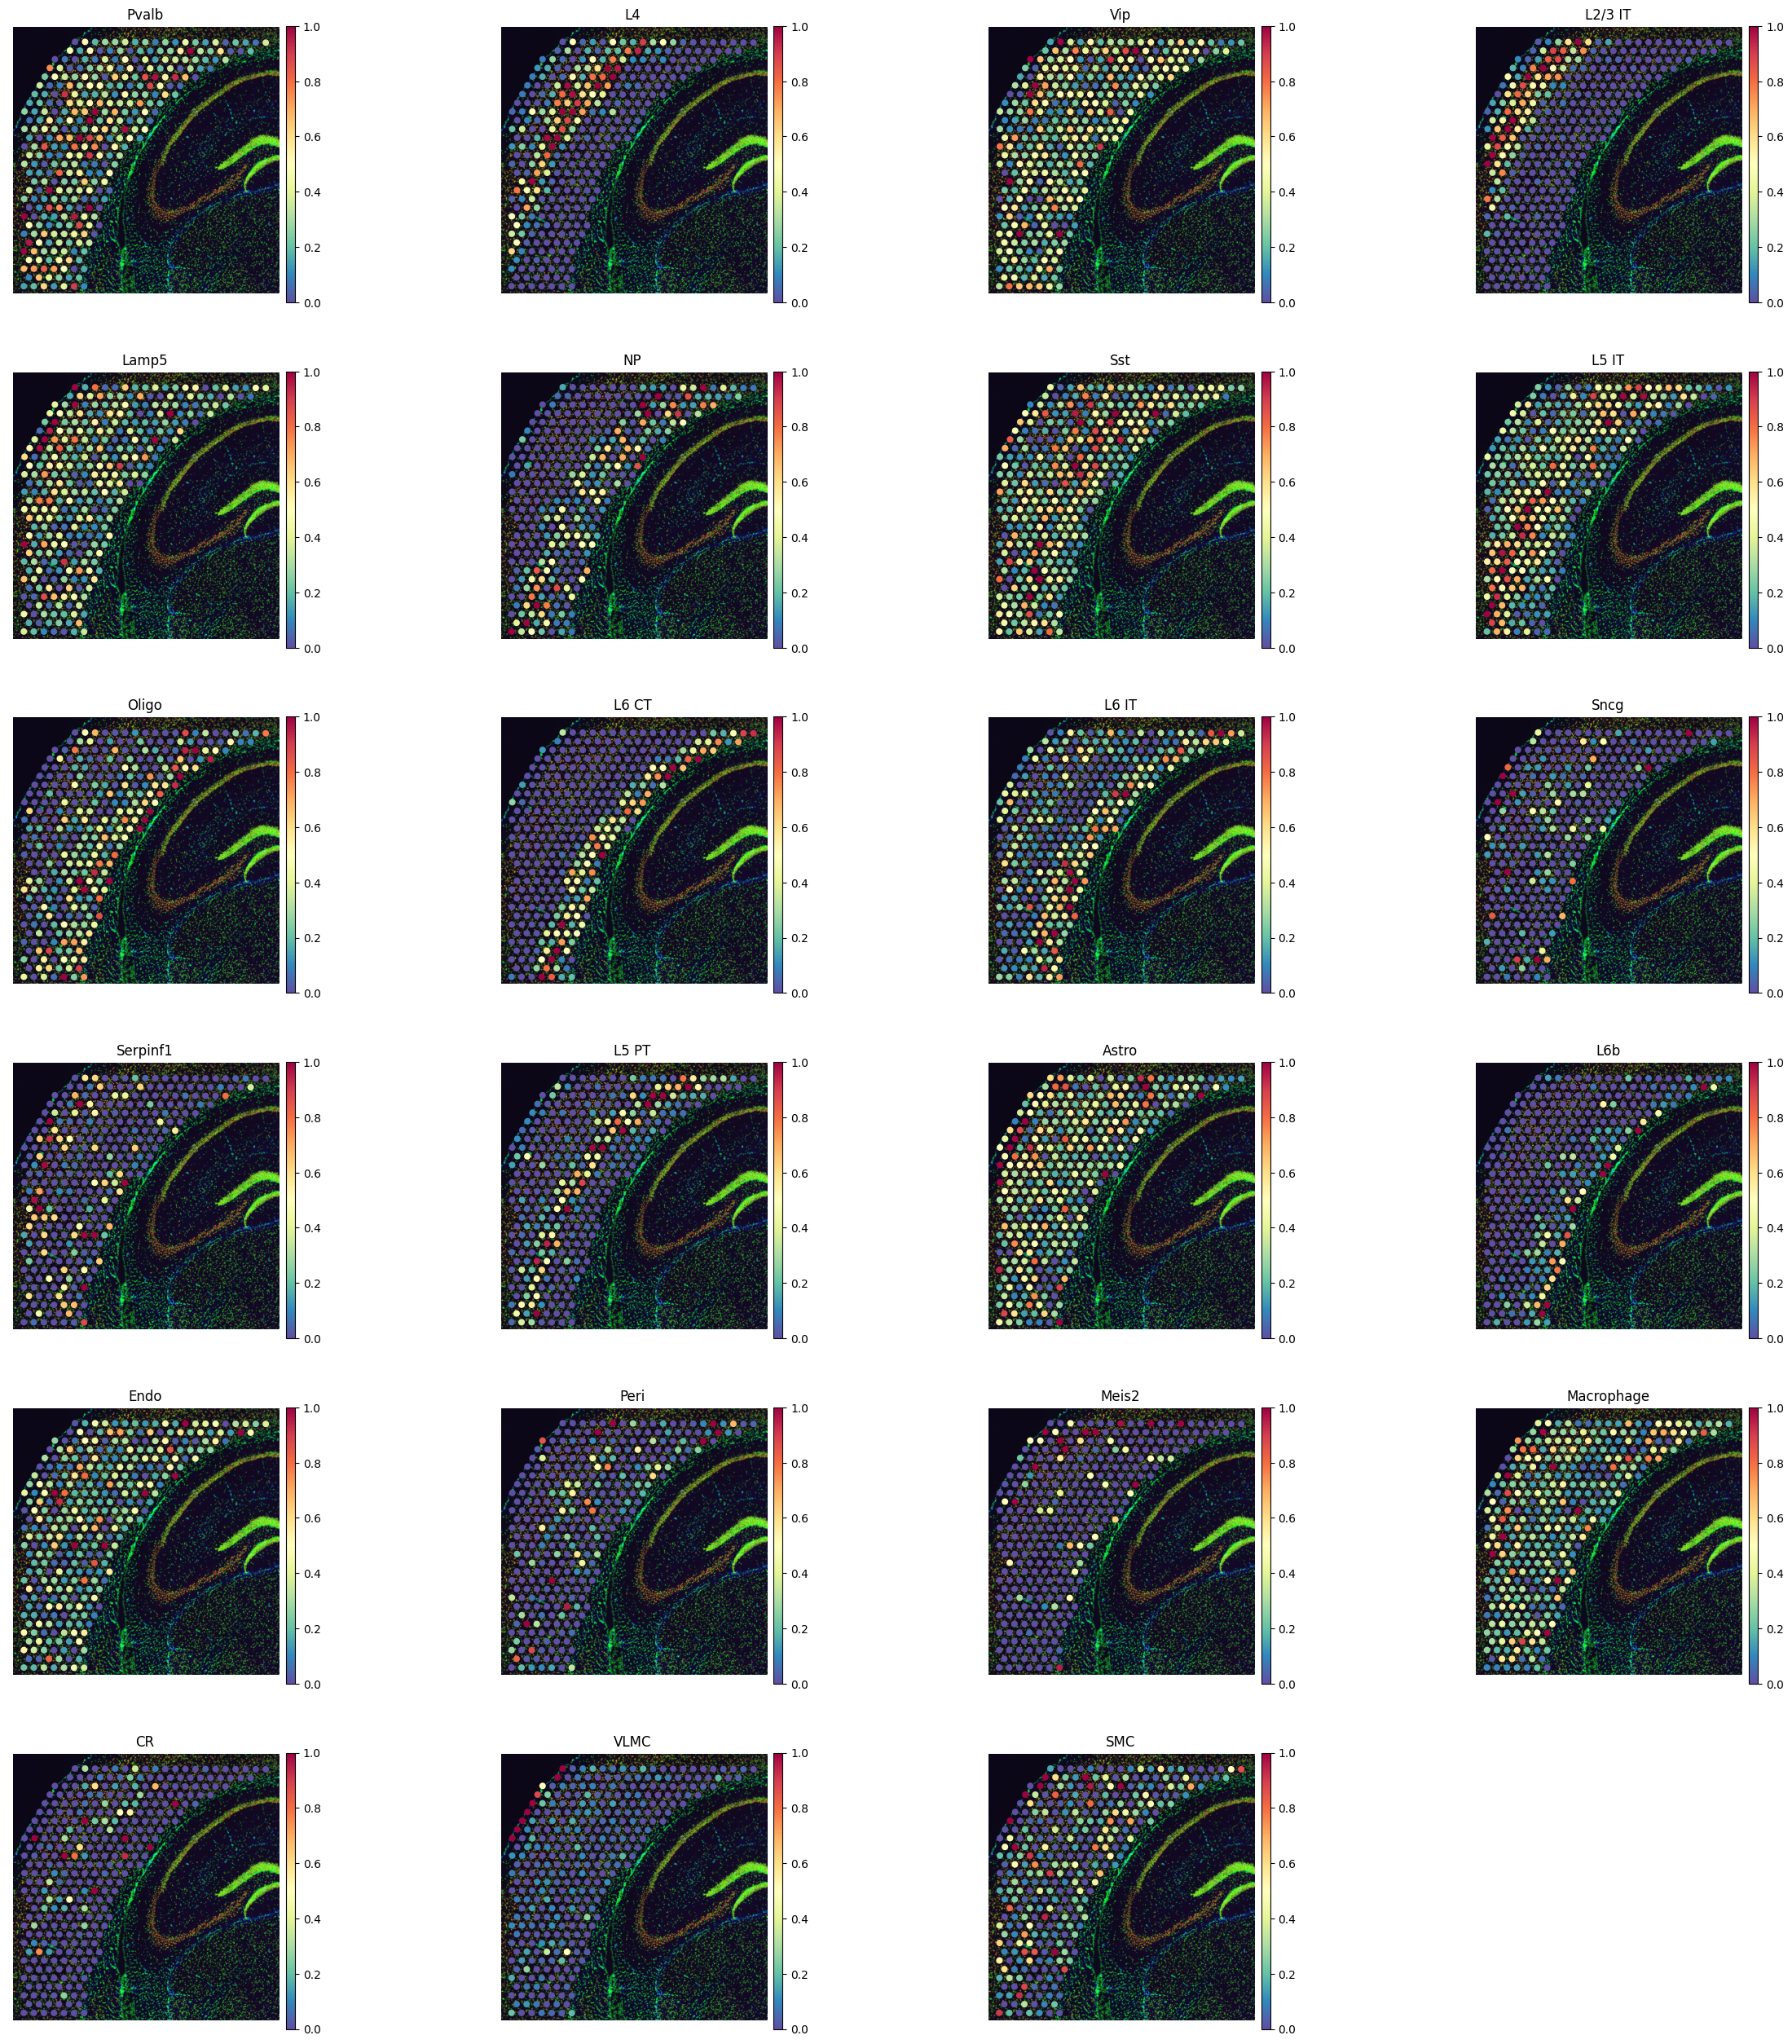

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
dt.project_cell_annotations(ad_map, adata_st, annotation="cell_subclass")
annotation_list = list(pd.unique(adata_sc.obs['cell_subclass']))
dt.plot_cell_annotation_sc1(adata_st, annotation_list,perc=0.02, cmap='Spectral_r', ncols=4,
                           scale_factor=adata_st.uns['spatial']['V1_Adult_Mouse_Brain_Coronal_Section_2']['scalefactors']['tissue_hires_scalef'])

In [16]:
ad_ge = dt.project_genes(adata_map=ad_map, adata_sc=adata_sc)
ad_ge

AnnData object with n_obs × n_vars = 324 × 36826
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'leiden', 'cluster', 'cell_count', 'uniform_density', 'rna_count_based_density'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'sparsity', 'is_training'
    uns: 'cell_class_colors', 'cell_subclass_colors', 'hvg', 'neighbors', 'pca', 'umap', 'log1p', 'rank_genes_groups', 'training_genes', 'overlap_genes'

In [17]:
ad_ge.uns['spatial'] = adata_st.uns['spatial'].copy()
ad_ge.obsm['spatial'] = adata_st.obsm['spatial'].copy()

In [18]:
df_all_genes = dt.compare_spatial_geneexp(ad_ge, adata_st, adata_sc)
df_all_genes

score  is_training  sparsity_sp  sparsity_sc  \
hspa8          9.975005e-01         True     0.000000     0.000784   
ppia           9.972653e-01         True     0.000000     0.000092   
gapdh          9.972501e-01         True     0.000000     0.000968   
atp1b1         9.972034e-01        False     0.000000     0.014334   
tmsb4x         9.970869e-01         True     0.000000     0.002811   
...                     ...          ...          ...          ...   
irx5           1.419255e-06        False     0.996914     0.999447   
cutal          3.581884e-07        False     0.996914     0.997696   
1810010k12rik  7.292536e-08        False     0.996914     0.999585   
dmrt3          1.533246e-08        False     0.996914     0.999263   
gm15133        2.075689e-09        False     0.996914     0.999170   

               sparsity_diff  
hspa8              -0.000784  
ppia               -0.000092  
gapdh              -0.000968  
atp1b1             -0.014334  
tmsb4x             -0.002811  
...                      ...  
irx5               -0.002533  
cutal              -0.000782  
1810010k12rik      -0.002672  
dmrt3              -0.002349  
gm15133            -0.002257  

[14785 rows x 5 columns]

In [19]:
dt.create_segment_cell_df(adata_st)
#adata_st.uns["tangram_cell_segmentation"]

In [20]:
dt.count_cell_annotations(
    ad_map,
    adata_sc,
    adata_st,
    annotation="cell_subclass",
)
#adata_st.obsm["tangram_ct_count"]

In [21]:
adata_segment = dt.deconvolve_cell_annotations(adata_st)
#adata_segment.obs

In [22]:
mapping_colors = {
    "L6_CT": (0.19215686274509805, 0.5098039215686274, 0.7411764705882353),
    "L6_IT": (0.4196078431372549, 0.6823529411764706, 0.8392156862745098),
    "NP": (0.6196078431372549, 0.792156862745098, 0.8823529411764706),
    "L6b": "#0000c2ff",
    "L2/3_IT": "#a1ed7bff",
    "L5_IT": (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
    "L5_ET": (0.4549019607843137, 0.7686274509803922, 0.4627450980392157),
    "Oligo": (0.4588235294117647, 0.4196078431372549, 0.6941176470588235),
    "Vip": (0.6196078431372549, 0.6039215686274509, 0.7843137254901961),
    "Astro": "#ffdd55ff",
    "L6_CT": "#000000ff",
    "Pvalb": (0.38823529411764707, 0.38823529411764707, 0.38823529411764707),
    "Lamp5": (0.5882352941176471, 0.5882352941176471, 0.5882352941176471),
    "Sst": (0.7411764705882353, 0.7411764705882353, 0.7411764705882353),
    "CR": (0.8509803921568627, 0.8509803921568627, 0.8509803921568627),
    "Sncg": (0.5176470588235295, 0.23529411764705882, 0.2235294117647059),
    "Peri": (0.6784313725490196, 0.28627450980392155, 0.2901960784313726),
    "VLMC": (0.8392156862745098, 0.3803921568627451, 0.4196078431372549),
    "Endo": (0.9058823529411765, 0.5882352941176471, 0.611764705882353),
    "Meis2": "#FFA500ff",
    "SMC": "#000000ff",
    "L6_PT": "#4682B4ff",
    "L5_PT": (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
    "L5_NP": "#6B8E23ff",
    "L4": "#d61f1dff",
    "Macrophage": "#2b2d2fff",
    "Serpinf1": "#000000ff",
}

In [23]:
newmeta = adata_segment.obs.copy()
newmeta.columns = newmeta.columns.str.replace(".", "-")
newmeta.insert(0, 'cell', newmeta.index)
newmeta["cell"] = newmeta["cell"].astype(int) + 1
newmeta["cell"] = "C" + newmeta["cell"].astype(str)
newmeta['spot'] = newmeta['centroids'].apply(lambda x: x.split('_')[0])
newmeta.rename(columns={'cluster': 'celltype'}, inplace=True)
newmeta["celltype"] = newmeta["celltype"].str.replace(" ", "_")
meta_data = newmeta[['cell','x','y','celltype']]

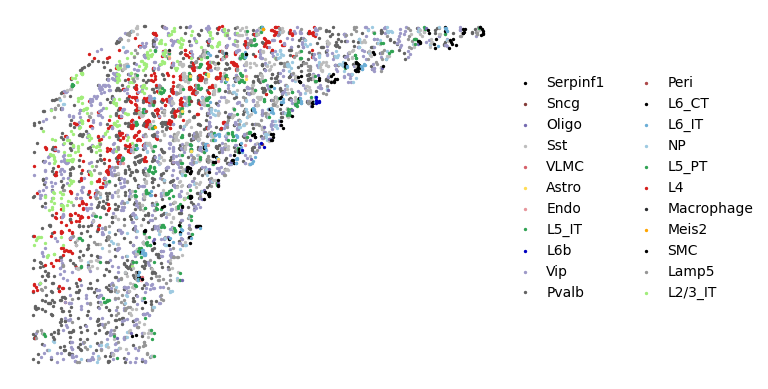

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
cluster = meta_data['celltype'].values
new_column_names = {'x': 'y', 'y': 'x'}
adata_segment.obs = adata_segment.obs.rename(columns=new_column_names)
dt.plot_cell_type_ST(adata_segment,mapping_colors,cluster)

## **Prediction of spatial CCC at the single-cell resolution.**
Train the data using subgraph-based GAT and generate a prediction model.

The training process may take some time.

The trained model can be used to predict intercellular communication mediated by other L-R interactions

In [25]:
Test_dir = './test/spot/'
isExists = os.path.exists(Test_dir)
if isExists:
    pass
else:
    os.makedirs(Test_dir)

In [26]:
index1 = [word.capitalize() for word in adata_sc.var.index]
c_list = [f'C{i}' for i in range(1, adata_sc.X.shape[0]+1)]
ad_sc = pd.DataFrame(adata_sc.X.T,index=index1,columns=c_list)

index1 = [word.capitalize() for word in ad_ge.var.index]
c_list = [word.capitalize() for word in ad_ge.obs.index]
ad_ge_new = pd.DataFrame(ad_ge.X.T,index=index1,columns=c_list)
st_obs = adata_segment.obs.copy()
sc_obs = adata_sc.obs.copy()

In [27]:
stnewdata = dt.New_ST_data_pre(ad_sc, ad_ge_new, st_obs, sc_obs, outdir = Test_dir)

In [28]:
pathways = Test_dir + "/pathways.csv"
#lrpairs = Test_dir + "/lrpairs_new.csv"
st_data = stnewdata
species = "Mouse"

**Generate training data.**

In [29]:
lrpairs_train = {
    'ligand': ['Mif'],
    'receptor': ['Epha5'],
    'species': ['Mouse']
}

lrpairs_train = pd.DataFrame(lrpairs_train)
lrpairs_train

ligand receptor species
0    Mif    Epha5   Mouse

In [30]:
dt.File_Train(st_data, pathways, lrpairs_train, meta_data, species, LR_train = 'Mif_Epha5',
              outdir =  Test_dir)

In [31]:
dt.data_for_train(st_data, data_dir = Test_dir +'/data/', 
	LR_train = 'Mif_Epha5')

**The process will take a long time, but we provide pre-trained models, so you can choose to skip this step.**

In [32]:
dt.Train(data_name = 'Mif_Epha5', data_path = Test_dir + '/data/',
    outdir = Test_dir + '/data/Mif_Epha5/output',
    pretrained_embeddings = Test_dir + '/data/Mif_Epha5/data_pca.emd',
    n_epochs = 50,ft_n_epochs=10)


 Loading graph...
DataSet Stats :
Number of Nodes 5044
Number of Edges 61086
Number of Node types 1
Number of relations 1
Graph with 5044 nodes and 61086 edges
5044 2
check torch.Size([5044, 128]) 5020
node2vec tensor torch.Size([5044, 128])
No. of nodes with pretrained embedding:  5044
No. edges in test data:  22942
***************PRETRAINING***************

 generate walks ...
no. of walks 40352
train ./test/spot//data//Mif_Epha5/outdir/Mif_Epha5_walks_train.txt
validate ./test/spot//data//Mif_Epha5/outdir/Mif_Epha5_walks_validate.txt
test ./test/spot//data//Mif_Epha5/outdir/Mif_Epha5_walks_test.txt

 Run model for pre-training ...

 Begin Training

Epoch: 0
MinLoss: 1000000.0, CurLoss: 8.6501
epoch time: (s) 68.51210856437683

Epoch: 10
MinLoss: 1000000.0, CurLoss: 8.4105
epoch time: (s) 64.37373161315918

Epoch: 20
MinLoss: 1000000.0, CurLoss: 7.8265
epoch time: (s) 66.30228304862976

Epoch: 30
MinLoss: 1000000.0, CurLoss: 7.1092
epoch time: (s) 63.97214436531067

Epoch: 40
MinLos

**Generate prediction data for Sema3c-Fzd3 pair.**

In [33]:
lrpairs_pre = {
    'ligand': ['Sema3c'],
    'receptor': ['Fzd3'],
    'species': ['Mouse']
}

lrpairs_pre = pd.DataFrame(lrpairs_pre)
lrpairs_pre

ligand receptor species
0  Sema3c     Fzd3   Mouse

In [34]:
dt.File_Pre(st_data, pathways, lrpairs_pre, meta_data, species, LR_Pre = 'Sema3c_Fzd3',
              outdir =  Test_dir)

In [35]:
dt.data_for_pre(st_data, data_dir = Test_dir +'/data/',
	LR_pre = 'Sema3c_Fzd3')

**Predicting cell-cell communication mediated by ```Sema3c_Fzd3```.**

In [36]:
dt.run_predict(data_name='Sema3c_Fzd3',data_path = Test_dir +'/data/',
    outdir = Test_dir +'/data/Sema3c_Fzd3/output',
    pretrained_embeddings = Test_dir +'/data/Sema3c_Fzd3/data_pca_test.emd',
    model_path = Test_dir+'/data/Mif_Epha5/output/finetune/results',best_id = 2, 
    is_trained = True, model_name = Test_dir + '/Mif_Epha5.model'
    )

DataSet Stats :
Number of Nodes 4624
Number of Edges 32577
Number of Node types 1
Number of relations 1
check torch.Size([4624, 128]) 4085
node2vec tensor torch.Size([4624, 128])
4 4 Linear(in_features=512, out_features=512, bias=True)
Begin Predicting
Done


## **Visualize of the spatial CCC**

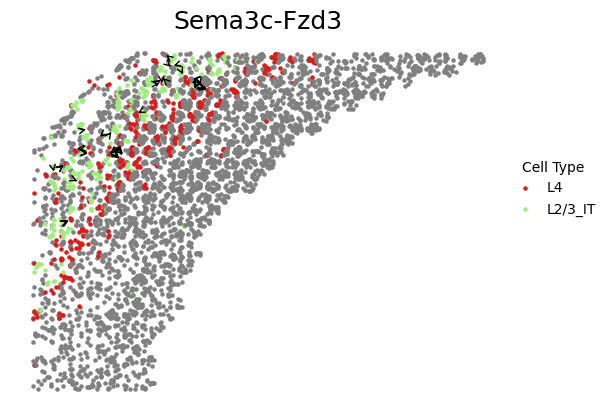

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt

dt.plot_CCC_ST(adata_segment, mapping_colors, cluster, st_data, ligand = 'Sema3c',
    receptor = 'Fzd3',CCC_label = Test_dir + '/data/Sema3c_Fzd3/predict_ccc.txt',
    sourcetype = 'L2/3_IT',targettype = 'L4',top_score = 50)

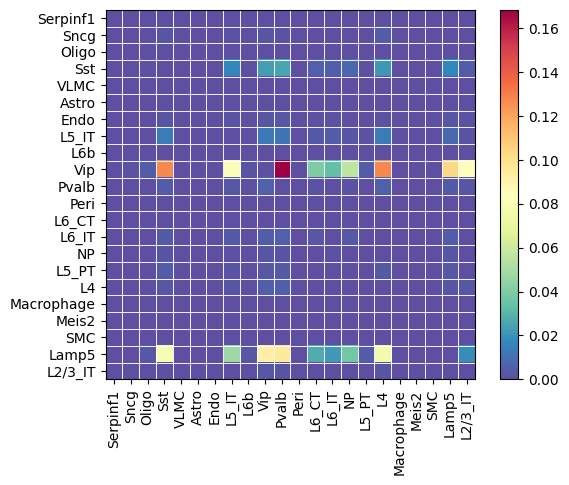

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
dt.plot_CCC_heatmap(cluster, st_data, ligand = 'Sema3c', receptor = 'Fzd3',
    CCC_label = Test_dir + '/data/Sema3c_Fzd3/predict_ccc.txt')